# Оптимальные питоновские реализация оптимизации ARTM

# Оптимизация произвольной функции

# Thetaless оптимизация


In [1]:
import numpy as np
from numpy.core.umath_tests import inner1d
import scipy
import scipy.sparse
from sklearn.datasets import fetch_20newsgroups
import gensim
from collections import Counter
import heapq
import nltk
import random
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
%matplotlib inline

# Разные функции потерь

In [2]:
class LogFunction(object):
    def calc(self, x):
        return np.log(x + 1e-20)
    def calc_der(self, x):
        return 1. / (x + 1e-20)
    

class IdFunction(object):
    def calc(self, x):
        return x + 1e-20
    def calc_der(self, x):
        return np.ones_like(x)
    

class SquareFunction(object):
    def calc(self, x):
        return (x + 1e-20) ** 2
    def calc_der(self, x):
        return 2. * (x + 1e-20) ** 2
    

class CubeLogFunction(object):
    def calc(self, x):
        return np.log(x + 1e-20) ** 3
    def calc_der(self, x):
        return 3. * np.log(x + 1e-20) ** 2 / (x + 1e-20)
    

class SquareLogFunction(object):
    def calc(self, x):
        return np.log(x + 1e-20) * np.abs(np.log(x + 1e-20))
    def calc_der(self, x):
        return 2. * np.abs(np.log(x + 1e-20)) / (x + 1e-20)

    
class FiveLogFunction(object):
    def calc(self, x):
        return np.log(x + 1e-20) ** 5
    def calc_der(self, x):
        return 5. * np.log(x + 1e-20) ** 4 / (x + 1e-20)
    

class CubeRootLogFunction(object):
    def calc(self, x):
        return np.cbrt(np.log(x + 1e-20))
    def calc_der(self, x):
        return 1. / 3 / (np.cbrt(np.log(x + 1e-20)) ** 2) / (x + 1e-20)
    
    
class SquareRootLogFunction(object):
    def calc(self, x):
        return np.sqrt(- np.log(x + 1e-20))
    def calc_der(self, x):
        return 1. / 2. / np.sqrt(- np.log(x + 1e-20)) / (x + 1e-20)
    

class ExpFunction(object):
    def calc(self, x):
        return np.exp(x)
    def calc_der(self, x):
        return np.exp(x)

    
class EntropyFunction(object):
    def calc(self, x):
        return (np.log(x + 1e-20) + 50.) * (x + 1e-20)
    def calc_der(self, x):
        return np.log(x + 1e-20) + 50.

# Разные регуляризации

In [3]:
def trivial_regularization(n_tw, n_dt):
    return np.zeros_like(n_tw), np.zeros_like(n_dt)

def create_reg_decorr(tau, theta_alpha=0.):
    def fun(n_tw, n_dt):
        phi_matrix = n_tw / np.sum(n_tw, axis=1)[:, np.newaxis]
        theta_matrix = n_dt / np.sum(n_dt, axis=1)[:, np.newaxis]
        aggr_phi = np.sum(phi_matrix, axis=1)
        return - tau * np.transpose(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix)), theta_alpha
    return fun

def create_reg_lda(phi_alpha, theta_alpha):
    def fun (n_tw, n_dt):
        return np.zeros_like(n_tw) + phi_alpha, np.zeros_like(n_dt) + theta_alpha
    return fun


# Подготовка Датасета

Нужно скачать некоторые коллекции данных и установить библиотеки (nltk, gensim)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tylorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
english_stopwords = set(stopwords.words('english'))

In [95]:
def prepare_dataset(dataset, calc_cooccurences=False, train_test_split=None, token_2_num=None):
    is_token_2_num_provided = token_2_num is not None 
    # remove stopwords
    if not is_token_2_num_provided:
        token_2_num = {}
        occurences = Counter()
        for i, doc in enumerate(dataset.data):
            tokens = gensim.utils.lemmatize(doc)
            for token in set(tokens):
                occurences[token] += 1
            if i % 500 == 0:
                print 'Processed: ', i, 'documents from', len(dataset.data)
    
    row, col, data = [], [], []
    row_test, col_test, data_test = [], [], []
    not_empty_docs_number = 0
    doc_targets = []
    doc_cooccurences = Counter()
    doc_occurences = Counter()
    random_gen = random.Random(42)
    
    for doc, target in zip(dataset.data, dataset.target):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        cnt_test = Counter()
        for token in tokens:
            word = token.split('/')[0]
            if not is_token_2_num_provided and word not in english_stopwords and 3 <= occurences[token] and token not in token_2_num:
                token_2_num[token] = len(token_2_num)
            if token in token_2_num:
                if train_test_split is None or random_gen.random() < train_test_split:
                    cnt[token_2_num[token]] += 1
                else:
                    cnt_test[token_2_num[token]] += 1
        
        if len(cnt) > 0 and (train_test_split is None or len(cnt_test) > 0):
            for w, c in cnt.iteritems():
                row.append(not_empty_docs_number)
                col.append(w)
                data.append(c)
                
            for w, c in cnt_test.iteritems():
                row_test.append(not_empty_docs_number)
                col_test.append(w)
                data_test.append(c)
                
            not_empty_docs_number += 1
            doc_targets.append(target)
            
            if calc_cooccurences:
                words = set(cnt.keys() + cnt_test.keys())
                doc_occurences.update(words)
                doc_cooccurences.update({(w1, w2) for w1 in words for w2 in words if w1 != w2})
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print 'Nonzero values:', len(data)
    if train_test_split is None:
        if calc_cooccurences:
            return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token, doc_targets, doc_occurences, doc_cooccurences
        else:
            return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token, doc_targets
    else:
        if calc_cooccurences:
            return (
                scipy.sparse.csr_matrix((data, (row, col))),
                scipy.sparse.csr_matrix((data_test, (row_test, col_test))),
                token_2_num,
                num_2_token,
                doc_targets,
                doc_occurences,
                doc_cooccurences
            )
        else:
            return (
                scipy.sparse.csr_matrix((data, (row, col))),
                scipy.sparse.csr_matrix((data_test, (row_test, col_test))),
                token_2_num,
                num_2_token,
                doc_targets
            )


In [105]:
dataset = fetch_20newsgroups(
    subset='all',
    categories=['sci.electronics', 'sci.med', 'sci.space', 'sci.crypt', 'rec.sport.baseball', 'rec.sport.hockey'],
    remove=('headers', 'footers', 'quotes')
)

In [106]:
%%time
origin_n_dw_matrix, token_2_num, num_2_token, doc_targets, doc_occurences, doc_cooccurences = prepare_dataset(dataset, calc_cooccurences=True)

Processed:  0 documents from 5945
Processed:  500 documents from 5945
Processed:  1000 documents from 5945
Processed:  1500 documents from 5945
Processed:  2000 documents from 5945
Processed:  2500 documents from 5945
Processed:  3000 documents from 5945
Processed:  3500 documents from 5945
Processed:  4000 documents from 5945
Processed:  4500 documents from 5945
Processed:  5000 documents from 5945
Processed:  5500 documents from 5945
Nonzero values: 322664
CPU times: user 10min 35s, sys: 4.76 s, total: 10min 39s
Wall time: 10min 40s


In [9]:
big_dataset = fetch_20newsgroups(
    subset='all',
    remove=('headers', 'footers', 'quotes')
)

In [145]:
%%time
big_origin_n_dw_matrix, _, _, big_doc_targets, big_doc_occurences, big_doc_cooccurences = prepare_dataset(big_dataset, calc_cooccurences=True)

Processed:  0 documents from 18846
Processed:  500 documents from 18846
Processed:  1000 documents from 18846
Processed:  1500 documents from 18846
Processed:  2000 documents from 18846
Processed:  2500 documents from 18846
Processed:  3000 documents from 18846
Processed:  3500 documents from 18846
Processed:  4000 documents from 18846
Processed:  4500 documents from 18846
Processed:  5000 documents from 18846
Processed:  5500 documents from 18846
Processed:  6000 documents from 18846
Processed:  6500 documents from 18846
Processed:  7000 documents from 18846
Processed:  7500 documents from 18846
Processed:  8000 documents from 18846
Processed:  8500 documents from 18846
Processed:  9000 documents from 18846
Processed:  9500 documents from 18846
Processed:  10000 documents from 18846
Processed:  10500 documents from 18846
Processed:  11000 documents from 18846
Processed:  11500 documents from 18846
Processed:  12000 documents from 18846
Processed:  12500 documents from 18846
Processed:

# Вычисление правдоподобных функций

### имеется в виду вычисление функций вида $\sum_{dw} n_{dw} f(\sum_{t} \phi_{wt} \theta_{td})$

##### Ключевой момент - использование функции inner1d. Она позволяет перемножить попарно строчки матриц, не сохраняя промежуточное состояние. А индексация в numpy не создаёт новый массив, делает view над ним. Таким образом, подсчёт $\sum_{t} \phi_{wt} \theta_{td}$  делается максимально эффективным способом и по времени и по памяти.

In [7]:
def create_calculate_likelihood_like_function(n_dw_matrix, loss_function=LogFunction()):
    D, W = n_dw_matrix.shape
    docptr = []
    indptr = n_dw_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    wordptr = n_dw_matrix.indices
    
    def fun(phi_matrix, theta_matrix):
        s_data = loss_function.calc(inner1d(theta_matrix[docptr, :], np.transpose(phi_matrix)[wordptr, :]))
        return np.sum(n_dw_matrix.data * s_data)

    return fun

# EM алгоритм

## Общая схема:
#### Неоходимо сначала вычислить $p_{tdw} = \frac{\phi_{wt} \theta_{td}}{\sum_s \phi_{ws} \theta_{sd}}$
#### Считаем $n_{wt} = \sum_d n_{dw} p_{tdw}$ и $n_{td} = \sum_w n_{dw} p_{tdw}$
#### Вычисляем $r_{wt}, r_{td}$ как функцию от $n_{wt}, n_{td}$
#### Прибавляем, делаем положительную срезку и нормируем

## Оптимизация вычисления:
#### Обозначим за $s_{dw}$ следующее выражение $\sum_t \phi_{wt} \theta_{td}$, фактически это наше предсказание для вероятности
####  Тогда $p_{tdw} = \frac{\phi_{wt} \theta_{td}}{s_{dw}}$
#### Подставим это выражение например в $n_wt$
#### И получим, что $n_{wt} = \sum_d n_{dw} \frac{\phi_{wt} \theta_{td}}{s_{dw}} = \phi_{wt} \sum_d \theta_{td} \cdot \frac{n_{dw}}{s_{dw}}$, аналогично $n_{td} = \theta_{td} \sum_w \phi_{wt} \cdot \frac{n_{dw}}{s_{dw}}$
#### Таким образом, мы видим, что фактически нам нужно знать матрицу $\frac{n_{dw}}{s_{dw}}$, а она очень разреженная, поэтому и $s_{dw}$ нужно не для всех пар вычислять, а только там, где $n_{dw} > 0$. 
#### То есть нам нужно эффективно закодить вычисление разженной матрицы $s_{dw}$ (матрица $n_{dw}$ уже есть в разреженном виде, так как подаётся на вход алгоритма), а затем просто поэлементно поделить
#### Причём хочется, чтобы промежуточные значения $p_{tdw}$ не сохранялись (как мы увидели, они в конечном варианте не важны)
#### Обозначим эту матрицу за $A$. Тогда $n_{wt} = \phi_{wt} (\Theta A)_{tw}$, а $n_{td} = \theta_{td} (A \Phi^T)_{dt}$.
#### Перемножить разреженную матрицу на плотную можно быстро, если правильно её хранить (по строкам, или по столбцам)
#### Если оптимизируется не правдоподобие, какая-то другая функция вида $\sum_{dw} n_{dw} f(s_{dw})$ (правдоподобие будет, если $f(x) = \ln x$ ) , то в этом случае нужно определить матрицу $A$ как $A_{dw} = n_{dw} f'(s_{dw})$

In [108]:
def em_optimization(
    n_dw_matrix, 
    phi_matrix,
    theta_matrix,
    regularization_list,
    iters_count=100,
    loss_function=LogFunction(),
    iteration_callback=None,
    const_phi=False
):
    D, W = n_dw_matrix.shape
    T = phi_matrix.shape[0]
    phi_matrix = np.copy(phi_matrix)
    theta_matrix = np.copy(theta_matrix)
    docptr = []
    indptr = n_dw_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    wordptr = n_dw_matrix.indices
    
    start_time = time.time()
    for it in xrange(iters_count):
        phi_matrix_tr = np.transpose(phi_matrix)
        # следующая строчка это 60% времени работы алгоритма
        s_data = loss_function.calc_der(inner1d(theta_matrix[docptr, :], phi_matrix_tr[wordptr, :]))
        # следующая часть это 25% времени работы алгоритма
        A = scipy.sparse.csr_matrix(
            (
                n_dw_matrix.data * s_data, 
                n_dw_matrix.indices, 
                n_dw_matrix.indptr
            ), 
            shape=n_dw_matrix.shape
        )
        A_tr = A.tocsc().transpose()
        # Остальное это 15% времени
        n_tw = np.transpose(A_tr.dot(theta_matrix)) * phi_matrix
        n_dt = A.dot(phi_matrix_tr) * theta_matrix
        
        r_tw, r_dt = regularization_list[it](n_tw, n_dt)
        n_tw += r_tw
        n_dt += n_dt
        n_tw[n_tw < 0] = 0
        n_dt[n_dt < 0] = 0
        
        if not const_phi:
            phi_matrix = n_tw / np.sum(n_tw, axis=1)[:, np.newaxis]
        theta_matrix = n_dt / np.sum(n_dt, axis=1)[:, np.newaxis]
        
        if iteration_callback is not None:
            iteration_callback(it, phi_matrix, theta_matrix)
    
    print 'Iters time', time.time() - start_time
    return phi_matrix, theta_matrix

# Naive thetaless EM


### Основная идея: давайте вообще не хранить $\Theta$, а вместо этого вычислять её на лету одной итерацией ЕМ алгоритма, которую можно легко выписать.

##### Пусть тематический профиль документа инициализирован равномерно, то для этого документа $p_{tdw} = \frac{\phi_{wt}}{\sum_s \phi_s} \equiv \overline{\phi}_{wt} \equiv (\overline{\Phi})_{wt} \equiv p(t~|~w)$ . Эту матрицу легко рассчитать.
##### На первой итерации  будет подсчитано $n_{td} = \sum_{d} n_{dw} p_{tdw} = \sum_{d} n_{dw} (\overline{\Phi})_{wt} = (N\overline{\Phi})_{dt}$
##### И, соответственно, $\theta_{td} = \frac{n_{td}}{\sum_t n_{td}} =  \frac{n_{td}}{n_d}$
##### Введём матрицу $B_{dw} \equiv \frac{n_{dw}}{n_d}$, тогда $\Theta = B \overline{\Phi}$ 
##### Идеологически, мы зафиксировали, что $\Theta$ - детерминированная функция от $\Phi$. И теперь оптимизируем не $L(\Phi, \Theta)$, а $\overline{L}(\Phi) = L(\Phi, B \overline{\Phi})$
##### Наивность решения состоит в том, что мы полностью игнорируем любые действия с $\Theta$ на М шаге. То есть мы не считаем $n_{td}$ и не обновляем $\theta_{td}$ (этой матрицы вообще нет). А с $n_{wt}$ мы поступаем также как на обычном М шаге. Регуляризаторы на $\Phi$ обрабатываются точно также как и раньше ($r_{wt}$ прибавляется к $n_{wt}$), а регуляризаторы $\Theta$ игнорируются.

In [9]:
def naive_thetaless_em_optimization(
    n_dw_matrix, 
    phi_matrix,
    regularization_list,
    iters_count=100,
    iteration_callback=None
):
    D, W = n_dw_matrix.shape
    T = phi_matrix.shape[0]
    phi_matrix = np.copy(phi_matrix)
    docptr = []
    indptr = n_dw_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    wordptr = n_dw_matrix.indices
    
    start_time = time.time()
    for it in xrange(iters_count):
        phi_rev_matrix = np.transpose(phi_matrix / np.sum(phi_matrix, axis=0))
        theta_matrix = n_dw_matrix.dot(phi_rev_matrix)
        theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]
        phi_matrix_tr = np.transpose(phi_matrix)
        
        s_data = 1. / inner1d(theta_matrix[docptr, :], phi_matrix_tr[wordptr, :])
        A = scipy.sparse.csr_matrix(
            (
                n_dw_matrix.data  * s_data , 
                n_dw_matrix.indices, 
                n_dw_matrix.indptr
            ), 
            shape=n_dw_matrix.shape
        ).tocsc()
            
        n_tw = (A.T.dot(theta_matrix)).T * phi_matrix
        r_tw, _ = regularization_list[it](n_tw, theta_matrix)
        n_tw += r_tw
        n_tw[n_tw < 0] = 0
        phi_matrix = n_tw / np.sum(n_tw, axis=1)[:, np.newaxis]

        if iteration_callback is not None:
            iteration_callback(it, phi_matrix, theta_matrix)
    
    print 'Iters time', time.time() - start_time    
    return phi_matrix, theta_matrix

# ARTM thetaless EM optimization

##### Данное решение исправляет "наивность" предыдущего подхода, учитывая зависимость от $\Theta$. Фактически, это можно написать в виде регуляризатора. Чтобы понять, как именно это сделать, вспомним как работает EM алгоритм.

##### На каждой итерации сначала определяются $p_{tdw}$, фиксируются, а затем строится функционал нижней оценки: $Q(\Phi, \Theta) = \sum_{dtw} n_{dw} p_{tdw} \left( \ln \phi_{wt} + \ln \theta_{td}\right) + R(\Phi, \Theta)$. Цель М-шага увеличить значение данного функционала по сравнению с $\Phi$ и $\Theta$ с предыдущей итерации.

##### Несмотря на то, что теперь $\Theta$ это функция от $\Phi$, тот факт, что это всё ещё нижняя оценка, никуда не пропадает. Поэтому теперь наша цель подобрать $\Phi$, чтобы увеличить значение по сравнению с $\Phi$ с предыдущей итерации следующий функционал: 

$\sum_{dtw} n_{dw} p_{tdw} \left( \ln \phi_{wt} + \ln (\Theta(\Phi))_{dt}\right) + R(\Phi, \Theta(\Phi))$.

##### Возьмём производные как обычно

##### $\frac{\partial{Q}}{\partial{\phi_{vr}}} = \frac{1}{\phi_{vr}} \left( \sum_{d} n_{dv} p_{rdv} + \phi_{vr} \frac{\partial{R}}{\partial{\phi_{vr}}} + \sum_{dtw} n_{dw} p_{tdw} \frac{1}{\theta_{td}} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} +  \sum_{dt} \frac{\partial{R}}{\partial{\theta_{td}}} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} \right)$

##### Так как $p_{tdw} = \frac{\phi_{wt} \theta_{td}}{\sum_s \phi_{ws} \theta_{sd}}$, то третье слагаемое можно упростить

##### $\sum_{dtw} n_{dw} p_{tdw} \frac{1}{\theta_{td}} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} = \sum_{dtw} n_{dw}\frac{\phi_{wt}}{\sum_s \phi_{ws} \theta_{sd}} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} = \sum_{dtw} A_{dw} \phi_{wt} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}}$

##### Итого

##### $\frac{\partial{Q}}{\partial{\phi_{vr}}} = \frac{1}{\phi_{vr}} \left( \sum_{d} n_{dv} p_{rdv} + \phi_{vr}\left( \frac{\partial{R}}{\partial{\phi_{vr}}} + \sum_{dtw} A_{dw} \phi_{wt} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} +  \sum_{dt} \frac{\partial{R}}{\partial{\theta_{td}}} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} \right) \right)$

##### Обозначим за $C = A \Phi^T + \frac{\partial{R}}{\partial{\Theta}}$, тогда
$\frac{\partial{Q}}{\partial{\phi_{vr}}} = \frac{1}{\phi_{vr}} \left( \sum_{d} n_{dv} p_{rdv} + \phi_{vr}\left( \frac{\partial{R}}{\partial{\phi_{vr}}} + \sum_{dt} C_{dt} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} \right) \right)$

##### Как видим, получившийся остаток фактически и есть требуемый регуяризатор на $\Phi$. Осталось только найти $\frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}}$

##### $\theta_{td} = \sum_{w} B_{dw} \frac{\phi_{wt}}{\sum_s \phi_{ws}}$. Обозначим $\frac{1}{\sum_s \phi_{ws}}$ за $norm_w$, тогда

$\theta_{td} = \sum_{w} B_{dw} \phi_{wt} norm_w$

$\frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} =  \sum_{w} B_{dw}~norm_w \delta_{vwrt} +  \sum_{w} B_{dw} \phi_{wt} \frac{\partial{norm_w}}{\partial{\phi_{vr}}} = 
\sum_{w} B_{dw} norm_w \delta_{vwrt} - \sum_{w} B_{dw}~\phi_{wt}~norm_w^2~\delta_{vw} =
B_{dv}~norm_v~\delta_{rt} - B_{dv}~\phi_{vt}~norm_w^2
$

##### Тут $\delta$ это символ Кронекера

##### Теперь

$\sum_{dt} C_{dt} \frac{\partial{\theta_{td}}}{\partial{\phi_{vr}}} = \sum_{dt} C_{dt} \left( B_{dv}~norm_v~\delta_{rt} - B_{dv}~\phi_{vt}~norm_v^2 \right) =  norm_v~\sum_d C_{dr} B_{dv} -  norm_v^2~\sum_{dt} C_{dt} B_{dv} \phi_{vt} = norm_v (C^T B)_{rv} - norm_v^2 (\Phi^T C^T B)_{vv}$

##### В numpy можно вычислить только диагональ при помощи einsum, поэтому эту регуляризационную добавку можно эффективно вычислить


In [10]:
def artm_thetaless_em_optimization(
    n_dw_matrix, 
    phi_matrix,
    regularization_list,
    iters_count=100,
    iteration_callback=None
):
    D, W = n_dw_matrix.shape
    T = phi_matrix.shape[0]
    phi_matrix = np.copy(phi_matrix)
    docptr = []
    docsizes = []
    indptr = n_dw_matrix.indptr
    for doc_num in xrange(D):
        size = indptr[doc_num + 1] - indptr[doc_num]
        docptr.extend([doc_num] * size)
        docsizes.extend([size] * size)
    docptr = np.array(docptr)
    wordptr = n_dw_matrix.indices
    docsizes = np.array(docsizes)
    
    B = scipy.sparse.csr_matrix(
        (
            1. * n_dw_matrix.data  / docsizes, 
            n_dw_matrix.indices, 
            n_dw_matrix.indptr
        ), 
        shape=n_dw_matrix.shape
    ).tocsc()
    
    start_time = time.time()
    for it in xrange(iters_count):
        word_norm = np.sum(phi_matrix, axis=0)
        word_norm[word_norm == 0] = 1e-20
        phi_rev_matrix = np.transpose(phi_matrix / word_norm)
        
        theta_matrix = n_dw_matrix.dot(phi_rev_matrix)
        theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]
        phi_matrix_tr = np.transpose(phi_matrix)
        
        s_data = 1. / inner1d(theta_matrix[docptr, :], phi_matrix_tr[wordptr, :])
        A = scipy.sparse.csr_matrix(
            (
                n_dw_matrix.data  * s_data , 
                n_dw_matrix.indices, 
                n_dw_matrix.indptr
            ), 
            shape=n_dw_matrix.shape
        ).tocsc()
            
        n_tw = A.T.dot(theta_matrix).T * phi_matrix
        
        r_tw, r_dt = regularization_list[it](n_tw, theta_matrix)
        theta_indices = theta_matrix > 0
        r_dt[theta_indices] /= theta_matrix[theta_indices]
        
        g_dt = A.dot(phi_matrix_tr) + r_dt
        tmp = g_dt.T * B / word_norm
        r_tw += (tmp - np.einsum('ij,ji->i', phi_rev_matrix, tmp)) * phi_matrix
        
        n_tw += r_tw
        n_tw[n_tw < 0] = 0
        phi_matrix = n_tw / np.sum(n_tw, axis=1)[:, np.newaxis]
        phi_matrix[np.isnan(phi_matrix)] = 0.

        if iteration_callback is not None:
            iteration_callback(it, phi_matrix, theta_matrix)
    
    print 'Iters time', time.time() - start_time    
    return phi_matrix, theta_matrix

# Gradient Descent

##### Мы можем найти градиент оптимизируемой функции и сделать шаг вдоль него. Сделано для сравнения.

In [11]:
def gradient_optimization(
    n_dw_matrix, 
    phi_matrix,
    theta_matrix,
    regularization_gradient_list,
    iters_count=100,
    loss_function=LogFunction(),
    iteration_callback=None,
    learning_rate=1.
):
    D, W = n_dw_matrix.shape
    T = phi_matrix.shape[0]
    phi_matrix = np.copy(phi_matrix)
    theta_matrix = np.copy(theta_matrix)
    docptr = []
    indptr = n_dw_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    wordptr = n_dw_matrix.indices
    
    start_time = time.time()
    for it in xrange(iters_count):
        phi_matrix_tr = np.transpose(phi_matrix)
        # следующая строчка это 60% времени работы алгоритма
        s_data = loss_function.calc_der(inner1d(theta_matrix[docptr, :], phi_matrix_tr[wordptr, :]))
        # следующая часть это 25% времени работы алгоритма
        A = scipy.sparse.csr_matrix(
            (
                n_dw_matrix.data * s_data, 
                n_dw_matrix.indices, 
                n_dw_matrix.indptr
            ), 
            shape=n_dw_matrix.shape
        ).tocsc()
        # Остальное это 15% времени
        g_tw = theta_matrix.T * A
        g_dt = A.dot(phi_matrix_tr)
        
        r_tw, r_dt = regularization_gradient_list[it](phi_matrix, theta_matrix)
        g_tw += r_tw
        g_dt += r_dt
        
        g_tw -= np.sum(g_tw * phi_matrix, axis=1)[:, np.newaxis]
        g_dt -= np.sum(g_dt * theta_matrix, axis=1)[:, np.newaxis]
        
        phi_matrix += g_tw * learning_rate
        theta_matrix += g_dt * learning_rate
        
        phi_matrix[phi_matrix < 0] = 0
        theta_matrix[theta_matrix < 0] = 0
        
        phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]
        theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]
        
        if iteration_callback is not None:
            iteration_callback(it, phi_matrix, theta_matrix)
    
    print 'Iters time', time.time() - start_time  
    return phi_matrix, theta_matrix

# Оценка качества классификации

In [100]:
def svm_score(theta, targets):
    C_2d_range = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    gamma_2d_range = [1e-3, 1e-2, 1e-1, 1, 1e1]
    best_C, best_gamma, best_val = None, None, 0.
    best_cv_algo_score_on_test = 0.
    X_train, X_test, y_train, y_test = train_test_split(theta, targets, test_size=0.30, stratify=targets, random_state=42)
    for C in C_2d_range:
        for gamma in gamma_2d_range:
            val = np.mean(cross_val_score(SVC(C=C, gamma=gamma), X_train, y_train, scoring='accuracy', cv=4))
            algo = SVC(C=C, gamma=gamma).fit(X_train, y_train)
            test_score = accuracy_score(y_test, algo.predict(X_test))
            print 'SVM(C={}, gamma={}) cv-score: {}  test-score: {}'.format(
                C,
                gamma,
                round(val, 3),
                round(test_score, 3)
            )
            if val > best_val:
                best_val = val
                best_C = C
                best_gamma = gamma
                best_cv_algo_score_on_test = test_score
    print '\n\n\nBest cv params: C={}, gamma={}\nCV score: {}\nTest score:{}'.format(
        best_C,
        best_gamma,
        round(best_val, 3),
        round(best_cv_algo_score_on_test, 3)
    )
    return best_C, best_gamma, best_val, best_cv_algo_score_on_test

In [13]:
def artm_calc_topic_correlation(phi):
    T, W = phi.shape
    return (np.sum(np.sum(phi, axis=0) ** 2) - np.sum(phi ** 2)) / (T * (T - 1))

In [14]:
def artm_calc_perplexity_factory(n_dw_matrix):
    helper = create_calculate_likelihood_like_function(
        loss_function=LogFunction(),
        n_dw_matrix=n_dw_matrix
    )
    total_words_number = n_dw_matrix.sum()
    return lambda phi, theta: np.exp(- helper(phi, theta) / total_words_number)     

In [15]:
def artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, documents_number, top_size):
    def fun(phi):
        T, W = phi.shape
        pmi = 0.
        for t in xrange(T):
            top = heapq.nlargest(top_size, xrange(W), key=lambda w: phi[t, w])
            for w1 in top:
                for w2 in top:
                    if w1 != w2:
                        pmi += np.log(documents_number * (doc_cooccurences[(w1, w2)] + 0.1) * 1. / doc_occurences[w1] / doc_occurences[w2])
        return pmi / (T * top_size * (top_size - 1))
    return fun

# Примеры запусков

# PLSA: EM optimization

In [127]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction(),
    iteration_callback=callback
)

phi, theta = em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction()
)

0 3986.0704926
1 3906.19009155
2 3816.50258883
3 3706.06393687
4 3572.34675498
5 3422.22011816
6 3268.08384344
7 3119.83183247
8 2983.70125846
9 2863.18846394
10 2759.69951822
11 2672.42541819
12 2599.05123244
13 2536.97312372
14 2483.83221649
15 2437.75378852
16 2397.31633049
17 2361.2891356
18 2328.82670318
19 2299.34993209
20 2272.58561051
21 2248.73220363
22 2227.65996306
23 2208.70765597
24 2191.35635596
25 2174.89348508
26 2159.11967244
27 2144.42764304
28 2131.28250351
29 2119.31240838
30 2108.36589959
31 2098.46248252
32 2089.30733262
33 2081.12016961
34 2073.44101797
35 2066.20339851
36 2059.38450385
37 2053.0078317
38 2046.96650212
39 2041.17463077
40 2035.4610121
41 2029.96956402
42 2024.71547536
43 2019.67900783
44 2014.82612812
45 2010.11252984
46 2005.54425925
47 2001.10582942
48 1996.92925567
49 1993.06135312
50 1989.37842384
51 1985.82831163
52 1982.42779562
53 1979.20828384
54 1976.22776342
55 1973.49514204
56 1970.91173228
57 1968.36860342
58 1965.85370816
59 1963.405

In [128]:
phi_plsa_em = phi
theta_plsa_em = theta

In [130]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1890.44755589
Topic correlation 0.000472938245581
Avg top5 pmi 1.32100331417
Avg top10 pmi 1.14489311995
Avg top20 pmi 1.16503148316
Sparsity 0.672531979978


In [21]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.305  test-score: 0.486
SVM(C=0.1, gamma=0.1) cv-score: 0.676  test-score: 0.683
SVM(C=0.1, gamma=1) cv-score: 0.718  test-score: 0.722
SVM(C=0.1, gamma=10.0) cv-score: 0.728  test-score: 0.736
SVM(C=1.0, gamma=0.001) cv-score: 0.31  test-score: 0.493
SVM(C=1.0, gamma=0.01) cv-score: 0.673  test-score: 0.683
SVM(C=1.0, gamma=0.1) cv-score: 0.72  test-score: 0.723
SVM(C=1.0, gamma=1) cv-score: 0.742  test-score: 0.743
SVM(C=1.0, gamma=10.0) cv-score: 0.743  test-score: 0.745
SVM(C=10.0, gamma=0.001) cv-score: 0.672  test-score: 0.684
SVM(C=10.0, gamma=0.01) cv-score: 0.719  test-score: 0.723
SVM(C=10.0, gamma=0.1) cv-score: 0.74  test-score: 0.738
SVM(C=10.0, gamma=1) cv-score: 0.755  test-score: 0.743
SVM(C=10.0, gamma=10.0) cv-score: 0.725  test-score: 0.734
SVM(C=100.0, gamma=0.001) cv-score: 0.719  test-score: 0.722
SVM(C=100.0, gamma=0.01) cv-score: 0.739  test-score: 0.736
SVM(C=100.0, gam

# LDA: EM optimization

In [131]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = create_reg_lda(-0.1, -0.1)

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction(),
    iteration_callback=callback
)

phi, theta = em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction()
)

0 3987.37646827
1 3897.4074752
2 3798.04728921
3 3680.90916256
4 3546.86075721
5 3404.40082914
6 3264.35983653
7 3133.42614365
8 3015.05899483
9 2911.23100587
10 2822.68526189
11 2748.84376085
12 2687.63946797
13 2636.38528098
14 2592.68187264
15 2555.07686584
16 2523.26596425
17 2497.10117303
18 2475.8452058
19 2458.50015838
20 2444.08698345
21 2431.83457879
22 2421.18913973
23 2411.9411239
24 2403.92060151
25 2396.88272169
26 2390.67929499
27 2385.21190858
28 2380.39755883
29 2376.12819046
30 2372.32169245
31 2368.94321943
32 2365.92689874
33 2363.16733183
34 2360.63018304
35 2358.32615751
36 2356.24209776
37 2354.33902549
38 2352.5797764
39 2350.94714679
40 2349.42551463
41 2348.00372283
42 2346.66906665
43 2345.42598409
44 2344.2645335
45 2343.1731887
46 2342.13828756
47 2341.14797914
48 2340.19949656
49 2339.29619816
50 2338.44005861
51 2337.62109798
52 2336.83933634
53 2336.09686008
54 2335.38957787
55 2334.70918016
56 2334.04792875
57 2333.42233786
58 2332.83523389
59 2332.27917

In [132]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 2320.15559914
Topic correlation 0.000401210504811
Avg top5 pmi 1.13836129491
Avg top10 pmi 1.07842788999
Avg top20 pmi 1.09476761913
Sparsity 0.819639877642


In [25]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.602  test-score: 0.597
SVM(C=0.1, gamma=1) cv-score: 0.641  test-score: 0.641
SVM(C=0.1, gamma=10.0) cv-score: 0.655  test-score: 0.664
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.602  test-score: 0.595
SVM(C=1.0, gamma=0.1) cv-score: 0.641  test-score: 0.639
SVM(C=1.0, gamma=1) cv-score: 0.668  test-score: 0.675
SVM(C=1.0, gamma=10.0) cv-score: 0.662  test-score: 0.677
SVM(C=10.0, gamma=0.001) cv-score: 0.602  test-score: 0.594
SVM(C=10.0, gamma=0.01) cv-score: 0.641  test-score: 0.638
SVM(C=10.0, gamma=0.1) cv-score: 0.662  test-score: 0.663
SVM(C=10.0, gamma=1) cv-score: 0.676  test-score: 0.68
SVM(C=10.0, gamma=10.0) cv-score: 0.637  test-score: 0.66
SVM(C=100.0, gamma=0.001) cv-score: 0.64  test-score: 0.638
SVM(C=100.0, gamma=0.01) cv-score: 0.66  test-score: 0.66
SVM(C=100.0, gamma

# PLSA: naive thetaless EM optimization

In [133]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = naive_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    iteration_callback=callback
)

phi, theta = naive_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200
)

0 4028.35177178
1 4021.70284106
2 4010.85417715
3 3992.47680023
4 3962.57281777
5 3918.66130822
6 3858.60944736
7 3779.02320026
8 3678.00890305
9 3557.60111366
10 3424.09415717
11 3286.93928091
12 3155.88858099
13 3037.63331739
14 2934.65975247
15 2846.60272155
16 2771.81820433
17 2708.09139679
18 2653.23728614
19 2605.52734057
20 2563.82805547
21 2527.47902652
22 2496.01808851
23 2468.9673896
24 2445.77497288
25 2425.86697009
26 2408.70801891
27 2393.82768905
28 2380.85744338
29 2369.4991576
30 2359.4620215
31 2350.46863365
32 2342.29522488
33 2334.77867514
34 2327.84692884
35 2321.57292316
36 2316.02284294
37 2311.15125784
38 2306.84215015
39 2302.97900869
40 2299.47429011
41 2296.27278533
42 2293.34037007
43 2290.65809191
44 2288.1943657
45 2285.92025384
46 2283.81069361
47 2281.83589404
48 2279.96375713
49 2278.17297431
50 2276.45806591
51 2274.82519468
52 2273.27885688
53 2271.79915634
54 2270.35432729
55 2268.92474786
56 2267.50940967
57 2266.12473908
58 2264.8033004
59 2263.5754

In [134]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 2220.56651773
Topic correlation 0.000290318954988
Avg top5 pmi 1.02330066834
Avg top10 pmi 1.16376209817
Avg top20 pmi 1.21430217591
Sparsity 0.720724416018


In [29]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.784  test-score: 0.794
SVM(C=0.1, gamma=1) cv-score: 0.818  test-score: 0.817
SVM(C=0.1, gamma=10.0) cv-score: 0.824  test-score: 0.827
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.783  test-score: 0.796
SVM(C=1.0, gamma=0.1) cv-score: 0.821  test-score: 0.819
SVM(C=1.0, gamma=1) cv-score: 0.831  test-score: 0.832
SVM(C=1.0, gamma=10.0) cv-score: 0.837  test-score: 0.841
SVM(C=10.0, gamma=0.001) cv-score: 0.782  test-score: 0.795
SVM(C=10.0, gamma=0.01) cv-score: 0.821  test-score: 0.819
SVM(C=10.0, gamma=0.1) cv-score: 0.835  test-score: 0.83
SVM(C=10.0, gamma=1) cv-score: 0.841  test-score: 0.835
SVM(C=10.0, gamma=10.0) cv-score: 0.829  test-score: 0.832
SVM(C=100.0, gamma=0.001) cv-score: 0.821  test-score: 0.819
SVM(C=100.0, gamma=0.01) cv-score: 0.834  test-score: 0.826
SVM(C=100.0, g

##### Может быть матрица $\Phi$ от PLSA тоже хороша, если $\Theta$  по ней вычислить по нашим формулам (это одна итерация наивного алгоритма)

In [135]:
phi, theta = naive_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_plsa_em,
    regularization_list=regularization_list,
    iters_count=1
)

Iters time 0.0651209354401


In [136]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 2465.80644291
Topic correlation 0.000492166435216
Avg top5 pmi 1.19327254829
Avg top10 pmi 1.06846309606
Avg top20 pmi 1.10763352193
Sparsity 0.672712736374


In [33]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.627  test-score: 0.667
SVM(C=0.1, gamma=1) cv-score: 0.76  test-score: 0.763
SVM(C=0.1, gamma=10.0) cv-score: 0.795  test-score: 0.791
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.633  test-score: 0.664
SVM(C=1.0, gamma=0.1) cv-score: 0.759  test-score: 0.763
SVM(C=1.0, gamma=1) cv-score: 0.798  test-score: 0.791
SVM(C=1.0, gamma=10.0) cv-score: 0.811  test-score: 0.805
SVM(C=10.0, gamma=0.001) cv-score: 0.633  test-score: 0.663
SVM(C=10.0, gamma=0.01) cv-score: 0.76  test-score: 0.762
SVM(C=10.0, gamma=0.1) cv-score: 0.796  test-score: 0.787
SVM(C=10.0, gamma=1) cv-score: 0.807  test-score: 0.809
SVM(C=10.0, gamma=10.0) cv-score: 0.809  test-score: 0.808
SVM(C=100.0, gamma=0.001) cv-score: 0.76  test-score: 0.762
SVM(C=100.0, gamma=0.01) cv-score: 0.796  test-score: 0.79
SVM(C=100.0, gamm

Стало лучше, но не так хорошо как нашим методом + существенно менее разрежена + перплексия хуже

# PLSA: ARTM thetaless optimization

In [137]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    iteration_callback=callback
)

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200
)

0 4024.0085702
1 3991.50885265
2 3911.89488681
3 3756.1893153
4 3493.3368556
5 3171.316171
6 2915.60988676
7 2746.45369508
8 2635.80508596
9 2560.07395308
10 2505.06796354
11 2462.82826338
12 2429.00455576
13 2400.8921662
14 2377.21732813
15 2358.5833659
16 2343.64807915
17 2330.81632703
18 2319.79565166
19 2310.80408502
20 2303.31341941
21 2297.08052617
22 2291.69432531
23 2286.87792991
24 2282.7277651
25 2278.97319887
26 2275.56004815
27 2272.38892231
28 2269.57526931
29 2267.0551283
30 2264.7551971
31 2262.62370833
32 2260.66444089
33 2258.79769608
34 2257.03570419
35 2255.33731105
36 2253.74794326
37 2252.13412785
38 2250.58292352
39 2249.03407418
40 2247.53274389
41 2245.99435917
42 2244.35455335
43 2242.70489286
44 2241.0986306
45 2239.54583799
46 2238.1159281
47 2236.85119384
48 2235.71748512
49 2234.62317682
50 2233.62029424
51 2232.56358515
52 2231.63564977
53 2230.71625656
54 2230.02567909
55 2229.29650379
56 2228.6848943
57 2227.98746718
58 2227.44599568
59 2226.81180812
60 

In [138]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 2205.97416445
Topic correlation 8.79771042965e-05
Avg top5 pmi 1.245457939
Avg top10 pmi 1.45120011591
Avg top20 pmi 1.52730456693
Sparsity 0.823275862069


In [37]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.734  test-score: 0.746
SVM(C=0.1, gamma=1) cv-score: 0.789  test-score: 0.788
SVM(C=0.1, gamma=10.0) cv-score: 0.798  test-score: 0.803
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.738  test-score: 0.748
SVM(C=1.0, gamma=0.1) cv-score: 0.789  test-score: 0.786
SVM(C=1.0, gamma=1) cv-score: 0.808  test-score: 0.806
SVM(C=1.0, gamma=10.0) cv-score: 0.81  test-score: 0.809
SVM(C=10.0, gamma=0.001) cv-score: 0.738  test-score: 0.748
SVM(C=10.0, gamma=0.01) cv-score: 0.789  test-score: 0.786
SVM(C=10.0, gamma=0.1) cv-score: 0.807  test-score: 0.806
SVM(C=10.0, gamma=1) cv-score: 0.812  test-score: 0.808
SVM(C=10.0, gamma=10.0) cv-score: 0.805  test-score: 0.802
SVM(C=100.0, gamma=0.001) cv-score: 0.789  test-score: 0.786
SVM(C=100.0, gamma=0.01) cv-score: 0.806  test-score: 0.806
SVM(C=100.0, g

Качество классификации похоже на PLSA + наш метод вычисления $\Theta$, но разреженность существенно выше

# LDA: ARTM thetaless optimization

In [139]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = create_reg_lda(-0.1, -0.1)

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    iteration_callback=callback
)

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200
)

0 4030.28108815
1 3990.9897084
2 3899.38669268
3 3727.08282455
4 3451.68043309
5 3141.1961042
6 2913.58418182
7 2768.58796076
8 2675.21864029
9 2611.53083777
10 2565.34881792
11 2529.67850682
12 2501.16086618
13 2477.59867134
14 2458.31089648
15 2443.18033821
16 2431.27973344
17 2421.87860377
18 2413.8725605
19 2407.52647627
20 2402.61654245
21 2398.48972593
22 2394.94707993
23 2391.83264523
24 2389.27380383
25 2387.21154269
26 2385.47128783
27 2383.95824591
28 2382.65911143
29 2381.43303985
30 2380.36913475
31 2379.36922131
32 2378.46024322
33 2377.5461144
34 2376.7904632
35 2376.10054338
36 2375.42785366
37 2374.76881349
38 2374.17220415
39 2373.61299429
40 2373.11653376
41 2372.65077785
42 2372.25361927
43 2371.8543423
44 2371.4690954
45 2371.05433414
46 2370.67343122
47 2370.3074962
48 2369.90871946
49 2369.50302726
50 2369.0803948
51 2368.64942507
52 2368.21044045
53 2367.76265262
54 2367.31041267
55 2366.8733206
56 2366.4736494
57 2366.12933067
58 2365.86589031
59 2365.6245814
60

In [140]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 2365.66700264
Topic correlation 5.99072996027e-05
Avg top5 pmi 1.18756774579
Avg top10 pmi 1.41952043811
Avg top20 pmi 1.47183401218
Sparsity 0.885761957731


In [41]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.568  test-score: 0.649
SVM(C=0.1, gamma=1) cv-score: 0.731  test-score: 0.736
SVM(C=0.1, gamma=10.0) cv-score: 0.744  test-score: 0.747
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.572  test-score: 0.649
SVM(C=1.0, gamma=0.1) cv-score: 0.732  test-score: 0.736
SVM(C=1.0, gamma=1) cv-score: 0.749  test-score: 0.753
SVM(C=1.0, gamma=10.0) cv-score: 0.753  test-score: 0.744
SVM(C=10.0, gamma=0.001) cv-score: 0.572  test-score: 0.65
SVM(C=10.0, gamma=0.01) cv-score: 0.733  test-score: 0.735
SVM(C=10.0, gamma=0.1) cv-score: 0.747  test-score: 0.75
SVM(C=10.0, gamma=1) cv-score: 0.759  test-score: 0.753
SVM(C=10.0, gamma=10.0) cv-score: 0.746  test-score: 0.744
SVM(C=100.0, gamma=0.001) cv-score: 0.733  test-score: 0.734
SVM(C=100.0, gamma=0.01) cv-score: 0.747  test-score: 0.748
SVM(C=100.0, ga

# PLSA: gradient optimization

In [143]:
D, W = origin_n_dw_matrix.shape
T = 10

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=origin_n_dw_matrix
)

total_words_number = origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = gradient_optimization(
    n_dw_matrix=origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_gradient_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction(),
    iteration_callback=callback,
    learning_rate=1e-10
)

0 10077.0201076
1 9000.64995398
2 8289.15908634
3 7760.50577064
4 7342.67075424
5 6999.46812428
6 6709.96890275
7 6461.04857097
8 6243.80641146
9 6052.10960786
10 5881.43857375
11 5728.3868157
12 5590.31127508
13 5465.22617647
14 5351.36649016
15 5247.30909037
16 5152.03017834
17 5064.6228889
18 4984.24890204
19 4910.26260413
20 4842.07727317
21 4779.15688395
22 4721.02700376
23 4667.3711954
24 4617.78821401
25 4571.96402783
26 4529.63693079
27 4490.50908723
28 4454.33282924
29 4420.84640399
30 4389.84806195
31 4361.14183026
32 4334.5713221
33 4309.99315515
34 4287.24255502
35 4266.15147853
36 4246.5892184
37 4228.42562612
38 4211.54444688
39 4195.83746838
40 4181.18689862
41 4167.48956218
42 4154.67090928
43 4142.63700646
44 4131.32195601
45 4120.65886981
46 4110.59334532
47 4101.06769628
48 4092.03921378
49 4083.45569101
50 4075.2837242
51 4067.50378137
52 4060.08402337
53 4052.99081329
54 4046.20296281
55 4039.70004519
56 4033.45519261
57 4027.44872721
58 4021.68185388
59 4016.13942

In [144]:
print 'Perplexity', artm_calc_perplexity_factory(origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(doc_occurences, doc_cooccurences, origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 3790.91101076
Topic correlation 0.000550302870934
Avg top5 pmi 0.427162644713
Avg top10 pmi 0.425537991526
Avg top20 pmi 0.444101821971
Sparsity 0.59623192436


In [ ]:
svm_score(theta, doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=1) cv-score: 0.169  test-score: 0.169
SVM(C=0.1, gamma=10.0) cv-score: 0.174  test-score: 0.18
SVM(C=1.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=0.1) cv-score: 0.169  test-score: 0.169
SVM(C=1.0, gamma=1) cv-score: 0.177  test-score: 0.185
SVM(C=1.0, gamma=10.0) cv-score: 0.168  test-score: 0.183
SVM(C=10.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=10.0, gamma=0.01) cv-score: 0.169  test-score: 0.169
SVM(C=10.0, gamma=0.1) cv-score: 0.173  test-score: 0.187
SVM(C=10.0, gamma=1) cv-score: 0.173  test-score: 0.19
SVM(C=10.0, gamma=10.0) cv-score: 0.169  test-score: 0.172
SVM(C=100.0, gamma=0.001) cv-score: 0.169  test-score: 0.169
SVM(C=100.0, gamma=0.01) cv-score: 0.175  test-score: 0.188
SVM(C=100.0, ga

куда-то не туда сошёлся и очень плохие результаты

## На всей коллекции

### PLSA, EM

In [153]:
D, W = big_origin_n_dw_matrix.shape
T = 30

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=big_origin_n_dw_matrix
)

total_words_number = big_origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = em_optimization(
    n_dw_matrix=big_origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction(),
)

Iters time 176.533018112


In [154]:
big_plsa_phi_em = phi
big_plsa_theta_em = theta

In [155]:
print 'Perplexity', artm_calc_perplexity_factory(big_origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1414.64730681
Topic correlation 0.000386962147332
Avg top5 pmi 1.86098445613
Avg top10 pmi 1.90166746563
Avg top20 pmi 1.79886716599
Sparsity 0.842324748236


In [55]:
svm_score(theta, big_doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.01) cv-score: 0.054  test-score: 0.057
SVM(C=0.1, gamma=0.1) cv-score: 0.509  test-score: 0.535
SVM(C=0.1, gamma=1) cv-score: 0.554  test-score: 0.566
SVM(C=0.1, gamma=10.0) cv-score: 0.553  test-score: 0.568
SVM(C=1.0, gamma=0.001) cv-score: 0.054  test-score: 0.057
SVM(C=1.0, gamma=0.01) cv-score: 0.51  test-score: 0.536
SVM(C=1.0, gamma=0.1) cv-score: 0.557  test-score: 0.569
SVM(C=1.0, gamma=1) cv-score: 0.578  test-score: 0.59
SVM(C=1.0, gamma=10.0) cv-score: 0.572  test-score: 0.592
SVM(C=10.0, gamma=0.001) cv-score: 0.509  test-score: 0.536
SVM(C=10.0, gamma=0.01) cv-score: 0.557  test-score: 0.569
SVM(C=10.0, gamma=0.1) cv-score: 0.577  test-score: 0.587
SVM(C=10.0, gamma=1) cv-score: 0.584  test-score: 0.595
SVM(C=10.0, gamma=10.0) cv-score: 0.54  test-score: 0.57
SVM(C=100.0, gamma=0.001) cv-score: 0.557  test-score: 0.568
SVM(C=100.0, gamma=0.01) cv-score: 0.574  test-score: 0.582
SVM(C=100.0, gamm

In [156]:
phi, theta = naive_thetaless_em_optimization(
    n_dw_matrix=big_origin_n_dw_matrix, 
    phi_matrix=big_plsa_phi_em,
    regularization_list=regularization_list,
    iters_count=1
)

Iters time 0.925080060959


In [157]:
print 'Perplexity', artm_calc_perplexity_factory(big_origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1988.88347039
Topic correlation 0.000407564113863
Avg top5 pmi 1.80782976209
Avg top10 pmi 1.79368364694
Avg top20 pmi 1.75037595911
Sparsity 0.842531183782


In [59]:
svm_score(theta, big_doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.01) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.1) cv-score: 0.109  test-score: 0.214
SVM(C=0.1, gamma=1) cv-score: 0.546  test-score: 0.566
SVM(C=0.1, gamma=10.0) cv-score: 0.6  test-score: 0.61
SVM(C=1.0, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=1.0, gamma=0.01) cv-score: 0.108  test-score: 0.217
SVM(C=1.0, gamma=0.1) cv-score: 0.548  test-score: 0.566
SVM(C=1.0, gamma=1) cv-score: 0.603  test-score: 0.614
SVM(C=1.0, gamma=10.0) cv-score: 0.621  test-score: 0.641
SVM(C=10.0, gamma=0.001) cv-score: 0.107  test-score: 0.218
SVM(C=10.0, gamma=0.01) cv-score: 0.549  test-score: 0.566
SVM(C=10.0, gamma=0.1) cv-score: 0.603  test-score: 0.615
SVM(C=10.0, gamma=1) cv-score: 0.617  test-score: 0.64
SVM(C=10.0, gamma=10.0) cv-score: 0.626  test-score: 0.652
SVM(C=100.0, gamma=0.001) cv-score: 0.549  test-score: 0.566
SVM(C=100.0, gamma=0.01) cv-score: 0.603  test-score: 0.616
SVM(C=100.0, gamm

### PLSA, Naive Thetaless EM

In [158]:
D, W = big_origin_n_dw_matrix.shape
T = 30

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=big_origin_n_dw_matrix
)

total_words_number = big_origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = naive_thetaless_em_optimization(
    n_dw_matrix=big_origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200,
)

Iters time 178.381123781


In [159]:
print 'Perplexity', artm_calc_perplexity_factory(big_origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1711.55099784
Topic correlation 0.000175446626635
Avg top5 pmi 1.52647084897
Avg top10 pmi 1.65998347844
Avg top20 pmi 1.77594116676
Sparsity 0.873347969504


In [63]:
svm_score(theta, big_doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.01) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.1) cv-score: 0.333  test-score: 0.422
SVM(C=0.1, gamma=1) cv-score: 0.548  test-score: 0.572
SVM(C=0.1, gamma=10.0) cv-score: 0.58  test-score: 0.598
SVM(C=1.0, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=1.0, gamma=0.01) cv-score: 0.338  test-score: 0.427
SVM(C=1.0, gamma=0.1) cv-score: 0.551  test-score: 0.574
SVM(C=1.0, gamma=1) cv-score: 0.589  test-score: 0.602
SVM(C=1.0, gamma=10.0) cv-score: 0.599  test-score: 0.62
SVM(C=10.0, gamma=0.001) cv-score: 0.34  test-score: 0.427
SVM(C=10.0, gamma=0.01) cv-score: 0.552  test-score: 0.574
SVM(C=10.0, gamma=0.1) cv-score: 0.589  test-score: 0.603
SVM(C=10.0, gamma=1) cv-score: 0.594  test-score: 0.611
SVM(C=10.0, gamma=10.0) cv-score: 0.591  test-score: 0.613
SVM(C=100.0, gamma=0.001) cv-score: 0.552  test-score: 0.574
SVM(C=100.0, gamma=0.01) cv-score: 0.588  test-score: 0.602
SVM(C=100.0, gam

### PLSA, ARTM Thetaless EM

In [160]:
D, W = big_origin_n_dw_matrix.shape
T = 30

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=big_origin_n_dw_matrix
)

total_words_number = big_origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=big_origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=200,
)

Iters time 204.33359313


In [161]:
print 'Perplexity', artm_calc_perplexity_factory(big_origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1793.06954679
Topic correlation 2.65274620004e-05
Avg top5 pmi 2.19231523539
Avg top10 pmi 2.3588303139
Avg top20 pmi 2.40053604237
Sparsity 0.931713524259


In [68]:
svm_score(theta, big_doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.01) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.1) cv-score: 0.298  test-score: 0.34
SVM(C=0.1, gamma=1) cv-score: 0.517  test-score: 0.528
SVM(C=0.1, gamma=10.0) cv-score: 0.542  test-score: 0.548
SVM(C=1.0, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=1.0, gamma=0.01) cv-score: 0.302  test-score: 0.339
SVM(C=1.0, gamma=0.1) cv-score: 0.521  test-score: 0.529
SVM(C=1.0, gamma=1) cv-score: 0.55  test-score: 0.556
SVM(C=1.0, gamma=10.0) cv-score: 0.562  test-score: 0.572
SVM(C=10.0, gamma=0.001) cv-score: 0.303  test-score: 0.339
SVM(C=10.0, gamma=0.01) cv-score: 0.521  test-score: 0.529
SVM(C=10.0, gamma=0.1) cv-score: 0.55  test-score: 0.556
SVM(C=10.0, gamma=1) cv-score: 0.558  test-score: 0.568
SVM(C=10.0, gamma=10.0) cv-score: 0.552  test-score: 0.566
SVM(C=100.0, gamma=0.001) cv-score: 0.521  test-score: 0.529
SVM(C=100.0, gamma=0.01) cv-score: 0.55  test-score: 0.555
SVM(C=100.0, gamm

### LDA: EM optimiation

In [162]:
D, W = big_origin_n_dw_matrix.shape
T = 30

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = create_reg_lda(0.1, 0.1)

calc_log_likelihood = create_calculate_likelihood_like_function(
    loss_function=LogFunction(),
    n_dw_matrix=big_origin_n_dw_matrix
)

total_words_number = big_origin_n_dw_matrix.sum()
def callback(it, phi, theta):
    print it,  np.exp(- calc_log_likelihood(phi, theta) / total_words_number)

phi, theta = em_optimization(
    n_dw_matrix=big_origin_n_dw_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=200,
    loss_function=LogFunction(),
)

Iters time 187.479031086


In [ ]:
print 'Perplexity', artm_calc_perplexity_factory(big_origin_n_dw_matrix)(phi, theta)
print 'Topic correlation', artm_calc_topic_correlation(phi)
print 'Avg top5 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 5)(phi)
print 'Avg top10 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 10)(phi)
print 'Avg top20 pmi', artm_calc_pmi_top_factory(big_doc_occurences, big_doc_cooccurences, big_origin_n_dw_matrix.shape[0], 20)(phi)
print 'Sparsity', 1. * np.sum(phi < 1e-20) / np.sum(phi >= 0)

Perplexity 1459.35645641
Topic correlation 0.000338855991179
Avg top5 pmi 1.89148482225
Avg top10 pmi 1.86497231041
Avg top20 pmi 1.80513090211
Sparsity 0.0


In [ ]:
svm_score(theta, big_doc_targets)

SVM(C=0.1, gamma=0.001) cv-score: 0.054  test-score: 0.053
SVM(C=0.1, gamma=0.01) cv-score: 0.054  test-score: 0.061
SVM(C=0.1, gamma=0.1) cv-score: 0.507  test-score: 0.532
SVM(C=0.1, gamma=1) cv-score: 0.549  test-score: 0.564
SVM(C=0.1, gamma=10.0) cv-score: 0.545  test-score: 0.572
SVM(C=1.0, gamma=0.001) cv-score: 0.054  test-score: 0.061
SVM(C=1.0, gamma=0.01) cv-score: 0.509  test-score: 0.533
SVM(C=1.0, gamma=0.1) cv-score: 0.552  test-score: 0.568
SVM(C=1.0, gamma=1) cv-score: 0.577  test-score: 0.593
SVM(C=1.0, gamma=10.0) cv-score: 0.575  test-score: 0.599
SVM(C=10.0, gamma=0.001) cv-score: 0.509  test-score: 0.533
SVM(C=10.0, gamma=0.01) cv-score: 0.551  test-score: 0.567
SVM(C=10.0, gamma=0.1) cv-score: 0.573  test-score: 0.587
SVM(C=10.0, gamma=1) cv-score: 0.588  test-score: 0.605
SVM(C=10.0, gamma=10.0) cv-score: 0.547  test-score: 0.574
SVM(C=100.0, gamma=0.001) cv-score: 0.552  test-score: 0.567
SVM(C=100.0, gamma=0.01) cv-score: 0.571  test-score: 0.585
SVM(C=100.0, 

# С разделением на train и test по словам

In [16]:
dataset = fetch_20newsgroups(
    subset='all',
    categories=['sci.electronics', 'sci.med', 'sci.space', 'sci.crypt', 'rec.sport.baseball', 'rec.sport.hockey'],
    remove=('headers', 'footers', 'quotes')
)

In [17]:
%%time
train_n_dw_matrix, test_n_dw_matrix, ttt_token_2_num, ttt_num_2_token, ttt_doc_targets, ttt_doc_occurences, ttt_doc_cooccurences = prepare_dataset(dataset, calc_cooccurences=True, train_test_split=0.8)

Processed:  0 documents from 5945
Processed:  500 documents from 5945
Processed:  1000 documents from 5945
Processed:  1500 documents from 5945
Processed:  2000 documents from 5945
Processed:  2500 documents from 5945
Processed:  3000 documents from 5945
Processed:  3500 documents from 5945
Processed:  4000 documents from 5945
Processed:  4500 documents from 5945
Processed:  5000 documents from 5945
Processed:  5500 documents from 5945
Nonzero values: 268395
CPU times: user 6min 45s, sys: 3.75 s, total: 6min 49s
Wall time: 6min 49s


In [279]:
D, W = train_n_dw_matrix.shape
T = 15

base_train_perplexities = []
base_test_perplexities = []
base_sparsities = []
base_theta_sparsities = []
base_topic_correlations = []
base_avg_top5_pmis = []
base_avg_top10_pmis = []
base_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        loss_function=LogFunction(),
        iteration_callback=callback
    )
    
    base_train_perplexities.append(train_perplexity)
    base_test_perplexities.append(test_perplexity)
    base_sparsities.append(sparsity)
    base_theta_sparsities.append(theta_sparsity)
    base_topic_correlations.append(topic_correlation)
    base_avg_top5_pmis.append(avg_top5_pmi)
    base_avg_top10_pmis.append(avg_top10_pmi)
    base_avg_top20_pmis.append(avg_top20_pmi)

0
Iters time 42.7858760357
1
Iters time 42.4269461632
2
Iters time 42.1235029697
3
Iters time 41.8186860085
4
Iters time 41.4934561253
5
Iters time 42.5801270008
6
Iters time 43.6772708893
7
Iters time 43.6540520191
8
Iters time 41.9833059311
9
Iters time 42.2470920086
10
Iters time 40.8224620819
11
Iters time 41.3715980053
12
Iters time 41.452876091
13
Iters time 40.8841562271
14
Iters time 41.3481638432
15
Iters time 40.985530138
16
Iters time 40.7934269905
17
Iters time 40.2112569809
18
Iters time 41.7842080593
19
Iters time 41.0268828869
20
Iters time 40.282200098
21
Iters time 39.515198946
22
Iters time 41.0028369427
23
Iters time 40.1076960564
24
Iters time 40.4707169533
25
Iters time 41.7075710297
26
Iters time 40.9955649376
27
Iters time 41.3096129894
28
Iters time 40.3203868866
29
Iters time 39.7415869236


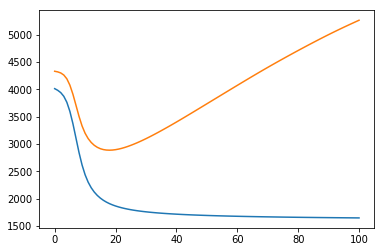

In [280]:
plt.plot(range(101), np.mean(base_train_perplexities, axis=0))
plt.plot(range(101), np.mean(base_test_perplexities, axis=0))
plt.show()

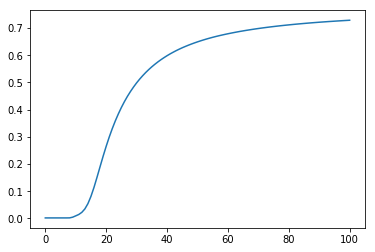

In [281]:
plt.plot(range(101), np.mean(base_sparsities, axis=0))
plt.show()

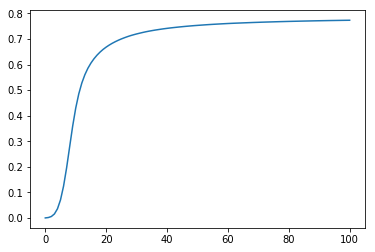

In [282]:
plt.plot(range(101), np.mean(base_theta_sparsities, axis=0))
plt.show()

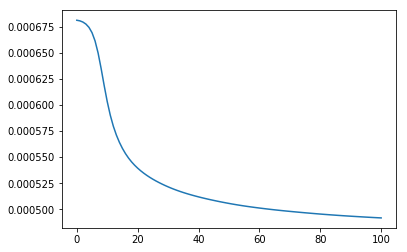

In [283]:
plt.plot(range(101), np.mean(base_topic_correlations, axis=0))
plt.show()

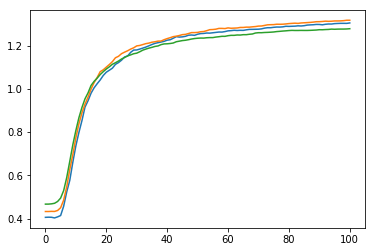

In [284]:
plt.plot(range(101), np.mean(base_avg_top5_pmis, axis=0))
plt.plot(range(101), np.mean(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.mean(base_avg_top20_pmis, axis=0))
plt.show()

In [285]:
D, W = train_n_dw_matrix.shape
T = 15

artm_train_perplexities = []
artm_test_perplexities = []
artm_sparsities = []
artm_theta_sparsities = []
artm_topic_correlations = []
artm_avg_top5_pmis = []
artm_avg_top10_pmis = []
artm_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = artm_thetaless_em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        iteration_callback=callback
    )
    
    artm_train_perplexities.append(train_perplexity)
    artm_test_perplexities.append(test_perplexity)
    artm_sparsities.append(sparsity)
    artm_theta_sparsities.append(theta_sparsity)
    artm_topic_correlations.append(topic_correlation)
    artm_avg_top5_pmis.append(avg_top5_pmi)
    artm_avg_top10_pmis.append(avg_top10_pmi)
    artm_avg_top20_pmis.append(avg_top20_pmi)


0
Iters time 43.7923359871
1
Iters time 43.4268069267
2
Iters time 42.4167251587
3
Iters time 43.0702729225
4
Iters time 42.5447909832
5
Iters time 42.325824976
6
Iters time 42.6001119614
7
Iters time 42.6850309372
8
Iters time 44.7434368134
9
Iters time 43.6948401928
10
Iters time 42.1222219467
11
Iters time 42.7449390888
12
Iters time 42.6191000938
13
Iters time 44.2115328312
14
Iters time 43.1528861523
15
Iters time 43.4118049145
16
Iters time 43.3559839725
17
Iters time 42.9977920055
18
Iters time 44.9373970032
19
Iters time 45.7696831226
20
Iters time 46.0244560242
21
Iters time 43.4269070625
22
Iters time 42.3577311039
23
Iters time 42.9004361629
24
Iters time 43.5502970219
25
Iters time 44.2389690876
26
Iters time 42.3832659721
27
Iters time 41.9999301434
28
Iters time 42.0280799866
29
Iters time 42.3533210754


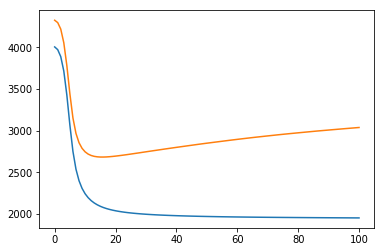

In [286]:
plt.plot(range(101), np.mean(artm_train_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_test_perplexities, axis=0))
plt.show()

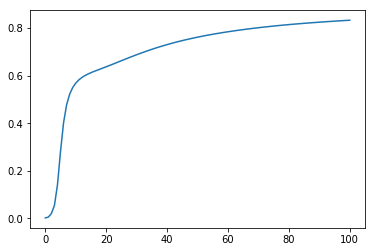

In [287]:
plt.plot(range(101), np.mean(artm_sparsities, axis=0))
plt.show()

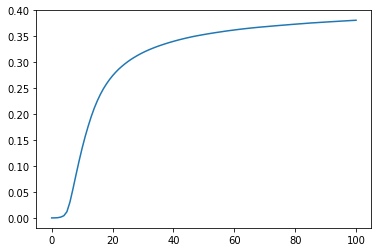

In [288]:
plt.plot(range(101), np.mean(artm_theta_sparsities, axis=0))
plt.show()

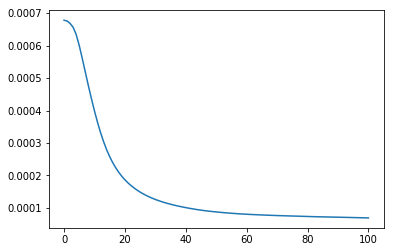

In [289]:
plt.plot(range(101), np.mean(artm_topic_correlations, axis=0))
plt.show()

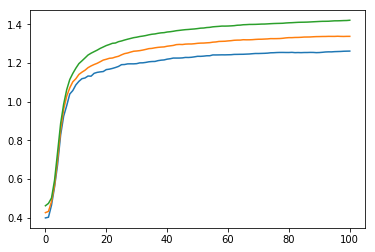

In [290]:
plt.plot(range(101), np.mean(artm_avg_top5_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top10_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top20_pmis, axis=0))
plt.show()

## Сравнение графиков

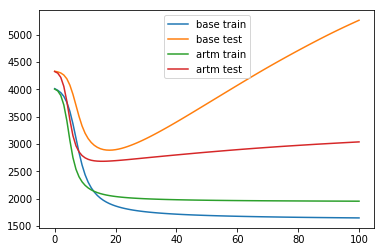

In [291]:
plt.plot(range(101), np.mean(base_train_perplexities, axis=0))
plt.plot(range(101), np.mean(base_test_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_train_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_test_perplexities, axis=0))
plt.legend(['base train', 'base test', 'artm train', 'artm test'])
plt.show()

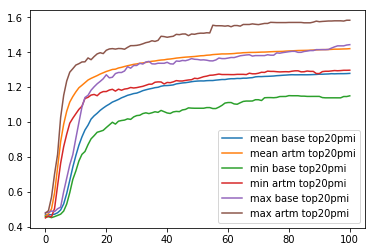

In [292]:
plt.plot(range(101), np.mean(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top20_pmis, axis=0))
plt.legend([
    'mean base top20pmi', 'mean artm top20pmi',
    'min base top20pmi', 'min artm top20pmi',
    'max base top20pmi', 'max artm top20pmi'
])
plt.show()

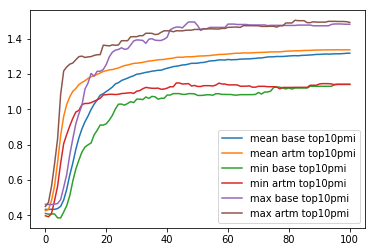

In [293]:
plt.plot(range(101), np.mean(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top10_pmis, axis=0))
plt.legend([
    'mean base top10pmi', 'mean artm top10pmi',
    'min base top10pmi', 'min artm top10pmi',
    'max base top10pmi', 'max artm top10pmi'
])
plt.show()

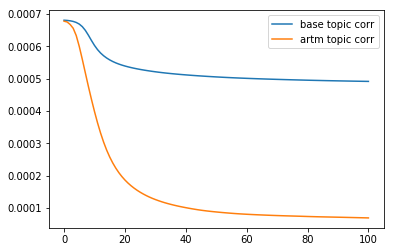

In [294]:
plt.plot(range(101), np.mean(base_topic_correlations, axis=0))
plt.plot(range(101), np.mean(artm_topic_correlations, axis=0))
plt.legend(['base topic corr', 'artm topic corr'])
plt.show()

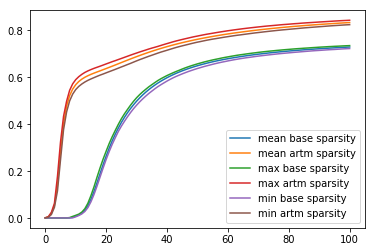

In [295]:
plt.plot(range(101), np.mean(base_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_sparsities, axis=0))
plt.plot(range(101), np.max(base_sparsities, axis=0))
plt.plot(range(101), np.max(artm_sparsities, axis=0))
plt.plot(range(101), np.min(base_sparsities, axis=0))
plt.plot(range(101), np.min(artm_sparsities, axis=0))
plt.legend([
    'mean base sparsity', 'mean artm sparsity', 
    'max base sparsity', 'max artm sparsity', 
    'min base sparsity', 'min artm sparsity'
])
plt.show()

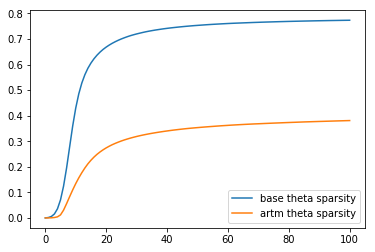

In [296]:
plt.plot(range(101), np.mean(base_theta_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_theta_sparsities, axis=0))
plt.legend(['base theta sparsity', 'artm theta sparsity'])
plt.show()

### То же самое, но тем меньше

In [297]:
D, W = train_n_dw_matrix.shape
T = 10

base_train_perplexities = []
base_test_perplexities = []
base_sparsities = []
base_theta_sparsities = []
base_topic_correlations = []
base_avg_top5_pmis = []
base_avg_top10_pmis = []
base_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        loss_function=LogFunction(),
        iteration_callback=callback
    )
    
    base_train_perplexities.append(train_perplexity)
    base_test_perplexities.append(test_perplexity)
    base_sparsities.append(sparsity)
    base_theta_sparsities.append(theta_sparsity)
    base_topic_correlations.append(topic_correlation)
    base_avg_top5_pmis.append(avg_top5_pmi)
    base_avg_top10_pmis.append(avg_top10_pmi)
    base_avg_top20_pmis.append(avg_top20_pmi)
    
    
artm_train_perplexities = []
artm_test_perplexities = []
artm_sparsities = []
artm_theta_sparsities = []
artm_topic_correlations = []
artm_avg_top5_pmis = []
artm_avg_top10_pmis = []
artm_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = artm_thetaless_em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        iteration_callback=callback
    )
    
    artm_train_perplexities.append(train_perplexity)
    artm_test_perplexities.append(test_perplexity)
    artm_sparsities.append(sparsity)
    artm_theta_sparsities.append(theta_sparsity)
    artm_topic_correlations.append(topic_correlation)
    artm_avg_top5_pmis.append(avg_top5_pmi)
    artm_avg_top10_pmis.append(avg_top10_pmi)
    artm_avg_top20_pmis.append(avg_top20_pmi)

0
Iters time 29.6899838448
1
Iters time 29.8602089882
2
Iters time 29.8688209057
3
Iters time 28.7798888683
4
Iters time 29.0384559631
5
Iters time 29.0897939205
6
Iters time 29.5434830189
7
Iters time 29.0106980801
8
Iters time 28.8640398979
9
Iters time 28.6725540161
10
Iters time 29.2300128937
11
Iters time 28.2852008343
12
Iters time 28.9245989323
13
Iters time 28.8655459881
14
Iters time 29.3361399174
15
Iters time 28.4799518585
16
Iters time 28.7663681507
17
Iters time 29.3651690483
18
Iters time 29.7869899273
19
Iters time 30.3056111336
20
Iters time 30.5270450115
21
Iters time 30.3568120003
22
Iters time 30.4477930069
23
Iters time 30.0380690098
24
Iters time 29.6101150513
25
Iters time 29.8326661587
26
Iters time 28.7443959713
27
Iters time 28.88438797
28
Iters time 29.0042080879
29
Iters time 29.0318000317
0
Iters time 30.7128129005
1
Iters time 30.5779340267
2
Iters time 31.3030622005
3
Iters time 31.221157074
4
Iters time 31.912512064
5
Iters time 31.7670149803
6
Iters time

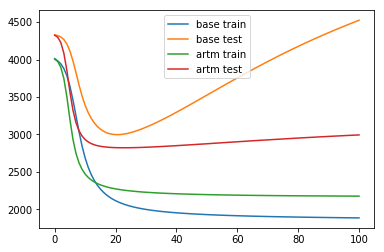

In [298]:
plt.plot(range(101), np.mean(base_train_perplexities, axis=0))
plt.plot(range(101), np.mean(base_test_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_train_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_test_perplexities, axis=0))
plt.legend(['base train', 'base test', 'artm train', 'artm test'])
plt.show()

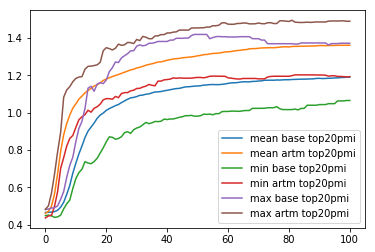

In [299]:
plt.plot(range(101), np.mean(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top20_pmis, axis=0))
plt.legend([
    'mean base top20pmi', 'mean artm top20pmi',
    'min base top20pmi', 'min artm top20pmi',
    'max base top20pmi', 'max artm top20pmi'
])
plt.show()

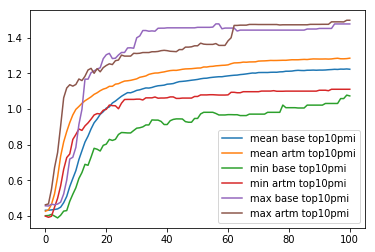

In [300]:
plt.plot(range(101), np.mean(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top10_pmis, axis=0))
plt.legend([
    'mean base top10pmi', 'mean artm top10pmi',
    'min base top10pmi', 'min artm top10pmi',
    'max base top10pmi', 'max artm top10pmi'
])
plt.show()

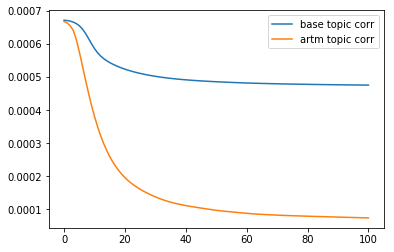

In [301]:
plt.plot(range(101), np.mean(base_topic_correlations, axis=0))
plt.plot(range(101), np.mean(artm_topic_correlations, axis=0))
plt.legend(['base topic corr', 'artm topic corr'])
plt.show()

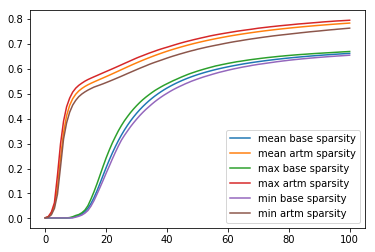

In [302]:
plt.plot(range(101), np.mean(base_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_sparsities, axis=0))
plt.plot(range(101), np.max(base_sparsities, axis=0))
plt.plot(range(101), np.max(artm_sparsities, axis=0))
plt.plot(range(101), np.min(base_sparsities, axis=0))
plt.plot(range(101), np.min(artm_sparsities, axis=0))
plt.legend([
    'mean base sparsity', 'mean artm sparsity', 
    'max base sparsity', 'max artm sparsity', 
    'min base sparsity', 'min artm sparsity'
])
plt.show()

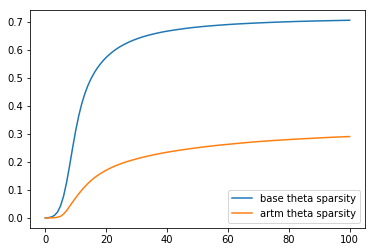

In [303]:
plt.plot(range(101), np.mean(base_theta_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_theta_sparsities, axis=0))
plt.legend(['base theta sparsity', 'artm theta sparsity'])
plt.show()

### То же самое но тем больше

In [304]:
D, W = train_n_dw_matrix.shape
T = 20

base_train_perplexities = []
base_test_perplexities = []
base_sparsities = []
base_theta_sparsities = []
base_topic_correlations = []
base_avg_top5_pmis = []
base_avg_top10_pmis = []
base_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        loss_function=LogFunction(),
        iteration_callback=callback
    )
    
    base_train_perplexities.append(train_perplexity)
    base_test_perplexities.append(test_perplexity)
    base_sparsities.append(sparsity)
    base_theta_sparsities.append(theta_sparsity)
    base_topic_correlations.append(topic_correlation)
    base_avg_top5_pmis.append(avg_top5_pmi)
    base_avg_top10_pmis.append(avg_top10_pmi)
    base_avg_top20_pmis.append(avg_top20_pmi)
    
    
artm_train_perplexities = []
artm_test_perplexities = []
artm_sparsities = []
artm_theta_sparsities = []
artm_topic_correlations = []
artm_avg_top5_pmis = []
artm_avg_top10_pmis = []
artm_avg_top20_pmis = []

for seed in xrange(30):
    print seed
    train_perplexity = []
    test_perplexity = []
    sparsity = []
    theta_sparsity = []
    topic_correlation = []
    avg_top5_pmi = []
    avg_top10_pmi = []
    avg_top20_pmi = []

    np.random.seed(seed)

    phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
    phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

    theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
    theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

    regularization_list = np.zeros(200, dtype=object)
    regularization_list[:] = create_reg_lda(0., 0.)

    _train_perplexity = artm_calc_perplexity_factory(train_n_dw_matrix) 
    _test_perplexity = artm_calc_perplexity_factory(test_n_dw_matrix)
    _top5_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 5)
    _top10_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 10)
    _top20_pmi = artm_calc_pmi_top_factory(ttt_doc_occurences, ttt_doc_cooccurences, train_n_dw_matrix.shape[0], 20)

    def callback(it, phi, theta):
        train_perplexity.append(_train_perplexity(phi, theta))
        test_perplexity.append(_test_perplexity(phi, theta))
        topic_correlation.append(artm_calc_topic_correlation(phi))
        sparsity.append(1. * np.sum(phi < 1e-20) / np.sum(phi >= 0))
        theta_sparsity.append(1. * np.sum(theta < 0.01) / np.sum(theta >= 0))
        avg_top5_pmi.append(_top5_pmi(phi))
        avg_top10_pmi.append(_top10_pmi(phi))
        avg_top20_pmi.append(_top20_pmi(phi))


    phi, theta = artm_thetaless_em_optimization(
        n_dw_matrix=train_n_dw_matrix, 
        phi_matrix=phi_matrix,
        regularization_list=regularization_list,
        iters_count=101,
        iteration_callback=callback
    )
    
    artm_train_perplexities.append(train_perplexity)
    artm_test_perplexities.append(test_perplexity)
    artm_sparsities.append(sparsity)
    artm_theta_sparsities.append(theta_sparsity)
    artm_topic_correlations.append(topic_correlation)
    artm_avg_top5_pmis.append(avg_top5_pmi)
    artm_avg_top10_pmis.append(avg_top10_pmi)
    artm_avg_top20_pmis.append(avg_top20_pmi)

0
Iters time 60.0656039715
1
Iters time 58.3242559433
2
Iters time 61.2478518486
3
Iters time 62.5005269051
4
Iters time 59.6023521423
5
Iters time 58.8537909985
6
Iters time 60.263425827
7
Iters time 61.2995100021
8
Iters time 60.2101080418
9
Iters time 60.9568171501
10
Iters time 61.9218728542
11
Iters time 59.9128370285
12
Iters time 60.3894519806
13
Iters time 60.8607540131
14
Iters time 60.0585050583
15
Iters time 59.214097023
16
Iters time 58.6959428787
17
Iters time 59.5804789066
18
Iters time 59.9895849228
19
Iters time 59.4596781731
20
Iters time 59.4532179832
21
Iters time 62.0023131371
22
Iters time 63.7705368996
23
Iters time 61.9603559971
24
Iters time 60.3882830143
25
Iters time 57.8210349083
26
Iters time 58.3218839169
27
Iters time 60.1407461166
28
Iters time 59.7574560642
29
Iters time 59.7064538002
0
Iters time 62.3934109211
1
Iters time 62.0195820332
2
Iters time 62.8939709663
3
Iters time 63.2815220356
4
Iters time 60.68836689
5
Iters time 60.596091032
6
Iters time 

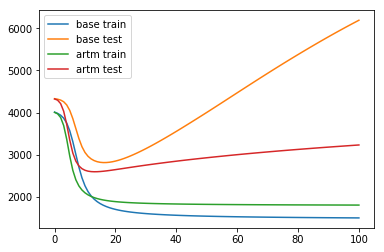

In [305]:
plt.plot(range(101), np.mean(base_train_perplexities, axis=0))
plt.plot(range(101), np.mean(base_test_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_train_perplexities, axis=0))
plt.plot(range(101), np.mean(artm_test_perplexities, axis=0))
plt.legend(['base train', 'base test', 'artm train', 'artm test'])
plt.show()

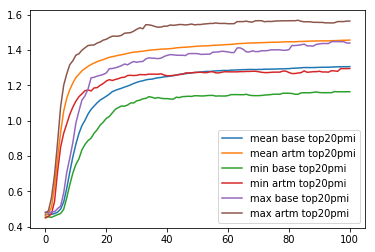

In [306]:
plt.plot(range(101), np.mean(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top20_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top20_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top20_pmis, axis=0))
plt.legend([
    'mean base top20pmi', 'mean artm top20pmi',
    'min base top20pmi', 'min artm top20pmi',
    'max base top20pmi', 'max artm top20pmi'
])
plt.show()

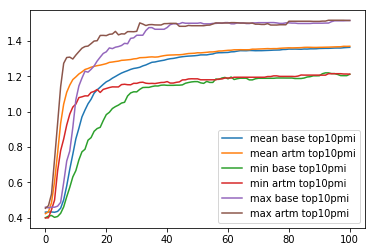

In [307]:
plt.plot(range(101), np.mean(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.mean(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.min(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.min(artm_avg_top10_pmis, axis=0))

plt.plot(range(101), np.max(base_avg_top10_pmis, axis=0))
plt.plot(range(101), np.max(artm_avg_top10_pmis, axis=0))
plt.legend([
    'mean base top10pmi', 'mean artm top10pmi',
    'min base top10pmi', 'min artm top10pmi',
    'max base top10pmi', 'max artm top10pmi'
])
plt.show()

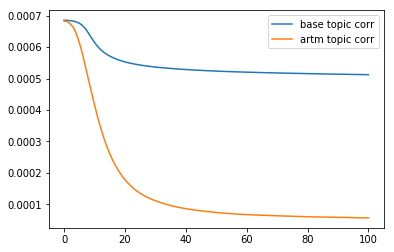

In [308]:
plt.plot(range(101), np.mean(base_topic_correlations, axis=0))
plt.plot(range(101), np.mean(artm_topic_correlations, axis=0))
plt.legend(['base topic corr', 'artm topic corr'])
plt.show()

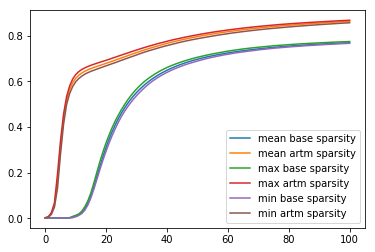

In [309]:
plt.plot(range(101), np.mean(base_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_sparsities, axis=0))
plt.plot(range(101), np.max(base_sparsities, axis=0))
plt.plot(range(101), np.max(artm_sparsities, axis=0))
plt.plot(range(101), np.min(base_sparsities, axis=0))
plt.plot(range(101), np.min(artm_sparsities, axis=0))
plt.legend([
    'mean base sparsity', 'mean artm sparsity', 
    'max base sparsity', 'max artm sparsity', 
    'min base sparsity', 'min artm sparsity'
])
plt.show()

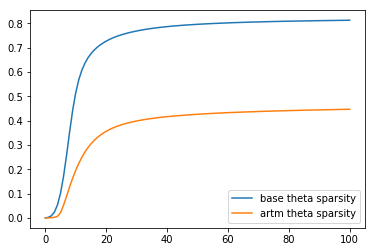

In [310]:
plt.plot(range(101), np.mean(base_theta_sparsities, axis=0))
plt.plot(range(101), np.mean(artm_theta_sparsities, axis=0))
plt.legend(['base theta sparsity', 'artm theta sparsity'])
plt.show()

# Разделение на train test по документам

In [98]:
dataset_train = fetch_20newsgroups(
    subset='train',
    categories=['sci.electronics', 'sci.med', 'sci.space', 'sci.crypt', 'rec.sport.baseball', 'rec.sport.hockey'],
    remove=('headers', 'footers', 'quotes')
)

In [99]:
%%time
n_dw_matrix_doc_train, token_2_num_doc_train, num_2_token_doc_train, doc_targets_doc_train = prepare_dataset(dataset_train)

Processed:  0 documents from 3570
Processed:  500 documents from 3570
Processed:  1000 documents from 3570
Processed:  1500 documents from 3570
Processed:  2000 documents from 3570
Processed:  2500 documents from 3570
Processed:  3000 documents from 3570
Processed:  3500 documents from 3570
Nonzero values: 199636
CPU times: user 4min 53s, sys: 228 ms, total: 4min 54s
Wall time: 4min 55s


In [101]:
dataset_test = fetch_20newsgroups(
    subset='test',
    categories=['sci.electronics', 'sci.med', 'sci.space', 'sci.crypt', 'rec.sport.baseball', 'rec.sport.hockey'],
    remove=('headers', 'footers', 'quotes')
)

In [102]:
%%time
n_dw_matrix_doc_test, token_2_num_doc_test, num_2_token_doc_test, doc_targets_doc_test = prepare_dataset(dataset_test, token_2_num=token_2_num_doc_train)

Nonzero values: 109917
CPU times: user 1min 11s, sys: 60 ms, total: 1min 11s
Wall time: 1min 11s


In [163]:
D, W = n_dw_matrix_doc_train.shape
T = 15

np.random.seed(777)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

phi, theta = em_optimization(
    n_dw_matrix=n_dw_matrix_doc_train, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    regularization_list=regularization_list,
    iters_count=150,
    loss_function=LogFunction()
)

best_C, best_gamma, _, _ = svm_score(theta, doc_targets_doc_train)
algo = SVC(C=best_C, gamma=best_gamma).fit(theta, doc_targets_doc_train)

Iters time 6.75549602509
SVM(C=0.1, gamma=0.001) cv-score: 0.208  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.208  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.724  test-score: 0.747
SVM(C=0.1, gamma=1) cv-score: 0.75  test-score: 0.767
SVM(C=0.1, gamma=10.0) cv-score: 0.748  test-score: 0.766
SVM(C=1.0, gamma=0.001) cv-score: 0.208  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.724  test-score: 0.746
SVM(C=1.0, gamma=0.1) cv-score: 0.757  test-score: 0.772
SVM(C=1.0, gamma=1) cv-score: 0.775  test-score: 0.78
SVM(C=1.0, gamma=10.0) cv-score: 0.78  test-score: 0.789
SVM(C=10.0, gamma=0.001) cv-score: 0.724  test-score: 0.746
SVM(C=10.0, gamma=0.01) cv-score: 0.757  test-score: 0.771
SVM(C=10.0, gamma=0.1) cv-score: 0.776  test-score: 0.789
SVM(C=10.0, gamma=1) cv-score: 0.791  test-score: 0.786
SVM(C=10.0, gamma=10.0) cv-score: 0.765  test-score: 0.786
SVM(C=100.0, gamma=0.001) cv-score: 0.757  test-score: 0.77
SVM(C=100.0, gamma=0.01) cv-score: 0.778  test-score

In [164]:
D, W = n_dw_matrix_doc_test.shape
theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

print 'PLSA not const phi' 
for iters in xrange(1, 11):
    _, theta_test = em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=iters,
        loss_function=LogFunction(),
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)

print '\nPLSA const phi' 
for iters in xrange(1, 11):
    _, theta_test = em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=iters,
        loss_function=LogFunction(),
        const_phi=True
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)
    
print '\nARTM thetaless'    
for iters in xrange(1, 11):
    _, theta_test = artm_thetaless_em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        regularization_list=regularization_list,
        iters_count=iters,
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)

PLSA not const phi
Iters time 0.027529001236
1 0.726835664336
Iters time 0.0562798976898
2 0.793706293706
Iters time 0.0812408924103
3 0.809003496503
Iters time 0.110112905502
4 0.808566433566
Iters time 0.140121936798
5 0.807255244755
Iters time 0.157828092575
6 0.808129370629
Iters time 0.200314998627
7 0.805506993007
Iters time 0.25125002861
8 0.801136363636
Iters time 0.248914957047
9 0.801136363636
Iters time 0.285149097443
10 0.801136363636

PLSA const phi
Iters time 0.0274460315704
1 0.726835664336
Iters time 0.0541310310364
2 0.807692307692
Iters time 0.0811920166016
3 0.817307692308
Iters time 0.110008001328
4 0.821678321678
Iters time 0.136802911758
5 0.815996503497
Iters time 0.163120031357
6 0.817307692308
Iters time 0.199345827103
7 0.815996503497
Iters time 0.216950893402
8 0.815996503497
Iters time 0.320188045502
9 0.815559440559
Iters time 0.31874704361
10 0.811625874126

ARTM thetaless
Iters time 0.0399160385132
1 0.726835664336
Iters time 0.0837988853455
2 0.763986013

In [165]:
D, W = n_dw_matrix_doc_train.shape
T = 15

np.random.seed(777)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

regularization_list = np.zeros(200, dtype=object)
regularization_list[:] = trivial_regularization

phi, theta = artm_thetaless_em_optimization(
    n_dw_matrix=n_dw_matrix_doc_train, 
    phi_matrix=phi_matrix,
    regularization_list=regularization_list,
    iters_count=150
)

best_C, best_gamma, _, _ = svm_score(theta, doc_targets_doc_train)
algo = SVC(C=best_C, gamma=best_gamma).fit(theta, doc_targets_doc_train)

Iters time 8.22832012177
SVM(C=0.1, gamma=0.001) cv-score: 0.203  test-score: 0.169
SVM(C=0.1, gamma=0.01) cv-score: 0.203  test-score: 0.169
SVM(C=0.1, gamma=0.1) cv-score: 0.317  test-score: 0.452
SVM(C=0.1, gamma=1) cv-score: 0.806  test-score: 0.814
SVM(C=0.1, gamma=10.0) cv-score: 0.819  test-score: 0.824
SVM(C=1.0, gamma=0.001) cv-score: 0.203  test-score: 0.169
SVM(C=1.0, gamma=0.01) cv-score: 0.317  test-score: 0.467
SVM(C=1.0, gamma=0.1) cv-score: 0.809  test-score: 0.822
SVM(C=1.0, gamma=1) cv-score: 0.824  test-score: 0.831
SVM(C=1.0, gamma=10.0) cv-score: 0.831  test-score: 0.836
SVM(C=10.0, gamma=0.001) cv-score: 0.317  test-score: 0.473
SVM(C=10.0, gamma=0.01) cv-score: 0.81  test-score: 0.822
SVM(C=10.0, gamma=0.1) cv-score: 0.824  test-score: 0.832
SVM(C=10.0, gamma=1) cv-score: 0.824  test-score: 0.83
SVM(C=10.0, gamma=10.0) cv-score: 0.812  test-score: 0.829
SVM(C=100.0, gamma=0.001) cv-score: 0.81  test-score: 0.822
SVM(C=100.0, gamma=0.01) cv-score: 0.824  test-scor

In [166]:
D, W = n_dw_matrix_doc_test.shape
theta_matrix = np.ones(shape=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]

print 'PLSA not const phi' 
for iters in xrange(1, 11):
    _, theta_test = em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=iters,
        loss_function=LogFunction(),
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)

print '\nPLSA const phi' 
for iters in xrange(1, 11):
    _, theta_test = em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        theta_matrix=theta_matrix,
        regularization_list=regularization_list,
        iters_count=iters,
        loss_function=LogFunction(),
        const_phi=True
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)
    
print '\nARTM thetaless'    
for iters in xrange(1, 11):
    _, theta_test = artm_thetaless_em_optimization(
        n_dw_matrix=n_dw_matrix_doc_test, 
        phi_matrix=phi,
        regularization_list=regularization_list,
        iters_count=iters,
    )
    print iters, accuracy_score(algo.predict(theta_test), doc_targets_doc_test)

PLSA not const phi
Iters time 0.0259470939636
1 0.806381118881
Iters time 0.051924943924
2 0.803321678322
Iters time 0.0790710449219
3 0.801136363636
Iters time 0.107365846634
4 0.797202797203
Iters time 0.131911039352
5 0.799825174825
Iters time 0.167650938034
6 0.798513986014
Iters time 0.215345144272
7 0.798513986014
Iters time 0.252720117569
8 0.798513986014
Iters time 0.278261899948
9 0.797202797203
Iters time 0.27599811554
10 0.798076923077

PLSA const phi
Iters time 0.0252859592438
1 0.806381118881
Iters time 0.051488161087
2 0.804195804196
Iters time 0.0791099071503
3 0.804632867133
Iters time 0.104104042053
4 0.804195804196
Iters time 0.131120204926
5 0.804195804196
Iters time 0.15819811821
6 0.80506993007
Iters time 0.183044910431
7 0.803758741259
Iters time 0.211533069611
8 0.803321678322
Iters time 0.23832988739
9 0.802447552448
Iters time 0.270797014236
10 0.80201048951

ARTM thetaless
Iters time 0.0357840061188
1 0.806381118881
Iters time 0.0703809261322
2 0.808129370629
